In [1]:
import warnings
warnings.filterwarnings('ignore')
import nvtabular as nvt
import cudf
import config
import os
# ignore warnings
from merlin.core.dispatch import get_lib
from merlin.schema.tags import Tags

import time
import merlin.models.tf as mm
# from dask.distributed import Client, wait
# from dask_cuda import LocalCUDACluster
# from dask.utils import parse_bytes

from merlin.schema.tags import Tags
from nvtabular.ops import *

from merlin.schema.tags import Tags
from merlin.io.dataset import Dataset
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

2023-09-09 13:48:08.206927: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-09 13:48:08.231365: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2023-09-09 13:48:09.217597: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-09 13:48:09.217825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-09 13:48:09.218033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

[INFO]: sparse_operation_kit is imported
[SOK INFO] Import /usr/local/lib/python3.8/dist-packages/merlin_sok-1.2.0-py3.8-linux-x86_64.egg/sparse_operation_kit/lib/libsok_experiment.so
[SOK INFO] Import /usr/local/lib/python3.8/dist-packages/merlin_sok-1.2.0-py3.8-linux-x86_64.egg/sparse_operation_kit/lib/libsok_experiment.so
[SOK INFO] Initialize finished, communication tool: horovod


2023-09-09 13:48:09.592387: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-09 13:48:09.592510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-09 13:48:09.592559: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:1013] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

In [2]:
train = pd.read_parquet(os.path.join(config.data_raw_dir,'transactions.parquet'))
customers = pd.read_parquet(os.path.join(config.data_raw_dir,'customers.parquet'))

encoder = LabelEncoder()
merged_ids = pd.concat([train['customer_id'], customers['customer_id']])
encoder.fit(merged_ids)
train['customer_id'] = encoder.transform(train['customer_id'])
customers['customer_id'] = encoder.transform(customers['customer_id'])
customers.to_parquet(os.path.join(config.data_processed_dir,'customers_enc.parquet'))
del customers




In [3]:
# convert  t_dat column to datetime
train['t_dat'] = pd.to_datetime(train['t_dat'])
train['week'] = 104 -(train['t_dat'].max() - train['t_dat']).dt.days // 7
start = 60
end = 90
valid = train[train.week>end]
train = train[(train.week>start) & (train.week<=end)]
in_train = valid[valid['customer_id'].isin(train['customer_id'])]
not_in_train = valid[~valid['customer_id'].isin(train['customer_id'])]


In [4]:
print('train shape', train.shape)
print('valid shape', valid.shape)
print('valid shape', in_train.shape)
print('not in train shape', not_in_train.shape)

train shape (8231156, 6)
valid shape (4453834, 6)
valid shape (3706105, 6)
not in train shape (747729, 6)


In [5]:
# sees number of customers in train and valid
print('train customers', train['customer_id'].nunique())
print('train customers', valid['customer_id'].nunique())
print('valid customers', in_train['customer_id'].nunique())
print('not in train customers', not_in_train['customer_id'].nunique())

train customers 780121
train customers 557962
valid customers 408937
not in train customers 149025


In [6]:
# see mean of number of rows with the same customer_id
print('mean of number of rows with the same customer_id in train', train.groupby('customer_id').count().mean())
print('mean of number of rows with the same customer_id in valid', valid.groupby('customer_id').count().mean())
print('mean of number of rows with the same customer_id in valid', in_train.groupby('customer_id').count().mean())
print('mean of number of rows with the same customer_id in not in train', not_in_train.groupby('customer_id').count().mean())

mean of number of rows with the same customer_id in train t_dat               10.551127
article_id          10.551127
price               10.551127
sales_channel_id    10.551127
week                10.551127
dtype: float64
mean of number of rows with the same customer_id in valid t_dat               7.982325
article_id          7.982325
price               7.982325
sales_channel_id    7.982325
week                7.982325
dtype: float64
mean of number of rows with the same customer_id in valid t_dat               9.062777
article_id          9.062777
price               9.062777
sales_channel_id    9.062777
week                9.062777
dtype: float64
mean of number of rows with the same customer_id in not in train t_dat               5.017474
article_id          5.017474
price               5.017474
sales_channel_id    5.017474
week                5.017474
dtype: float64


In [7]:
# number of rows with the same customer_id grater than 5 and less than 20
print('number of rows with the same customer_id grater than 5 and less than 20 in train', ((train.groupby('customer_id').count()>5) & (train.groupby('customer_id').count()<20)).sum())
print('number of rows with the same customer_id grater than 5 and less than 20 in valid', ((valid.groupby('customer_id').count()>5) & (valid.groupby('customer_id').count()<20)).sum())

print('number of rows with the same customer_id grater than 5 in train', (train.groupby('customer_id').count()>5).sum())
print('number of rows with the same customer_id grater than 5 in valid', (valid.groupby('customer_id').count()>5).sum())

number of rows with the same customer_id grater than 5 and less than 20 in train t_dat               296118
article_id          296118
price               296118
sales_channel_id    296118
week                296118
dtype: int64
number of rows with the same customer_id grater than 5 and less than 20 in valid t_dat               209686
article_id          209686
price               209686
sales_channel_id    209686
week                209686
dtype: int64
number of rows with the same customer_id grater than 5 in train t_dat               409013
article_id          409013
price               409013
sales_channel_id    409013
week                409013
dtype: int64
number of rows with the same customer_id grater than 5 in valid t_dat               255853
article_id          255853
price               255853
sales_channel_id    255853
week                255853
dtype: int64


In [8]:
# see how many 'customer_id' are common between the two datasets train and valid and also items 'article_id'
common = set(train['customer_id']).intersection(set(valid['customer_id']))
common_items = set(train['article_id']).intersection(set(valid['article_id']))
print('Number of common customers between train and valid: ', len(common))
print('Number of common items between train and valid: ', len(common_items))
print('Number of customers in train: ', len(train['customer_id'].unique()))
print('Number of customers in valid: ', len(valid['customer_id'].unique()))
print('Number of items in train: ', len(train['article_id'].unique()))
print('Number of items in valid: ', len(valid['article_id'].unique()))
print('Number of customers in valid but not in train: ', len(set(valid['customer_id']) - set(train['customer_id'])))
print('Number of items in valid but not in train: ', len(set(valid['article_id']) - set(train['article_id'])))
print('train shape: ', train.shape)
print('valid shape: ', valid.shape)

Number of common customers between train and valid:  408937
Number of common items between train and valid:  32819
Number of customers in train:  780121
Number of customers in valid:  557962
Number of items in train:  55238
Number of items in valid:  43640
Number of customers in valid but not in train:  149025
Number of items in valid but not in train:  10821
train shape:  (8231156, 6)
valid shape:  (4453834, 6)


In [9]:
save_dir = os.path.join(config.data_processed_dir,'train.parquet')
train.to_parquet(save_dir)

save_dir = os.path.join(config.data_processed_dir,'valid.parquet')
valid.to_parquet(save_dir)
print(len(train), len(valid))
del train, valid

8231156 4453834


In [10]:
ree

NameError: name 'ree' is not defined

In [ ]:
train = nvt.Dataset(os.path.join(config.data_processed_dir,'train', 'transactions.parquet'),engine="parquet",  part_mem_fraction=0.1)
valid = nvt.Dataset(os.path.join(config.data_processed_dir,'valid', 'transactions.parquet'),engine="parquet", part_mem_fraction=0.1)

In [ ]:
article_id = ["article_id"] >> Categorify() >> TagAsItemID()
customer_id = ["customer_id"] >> Categorify() >> TagAsUserID()
price = ["price"] >> FillMissing(fill_val=0) >> Normalize() >> TagAsItemFeatures()
len_session = ["price"] >> FillMissing(fill_val=0) >> Normalize() >> TagAsUserFeatures()


features = article_id + customer_id + price + len_session

wf = nvt.Workflow(features)
wf.fit_transform(train).to_parquet(os.path.join(config.data_processed_dir, 'train_processed.parquet'))
wf.transform(valid).to_parquet(os.path.join(config.data_processed_dir, 'validation_processed.parquet'))

wf.save(os.path.join(config.data_processed_dir, 'workflow'))

In [ ]:
train = Dataset(os.path.join(config.data_processed_dir, 'train_processed.parquet'))
valid = Dataset(os.path.join(config.data_processed_dir, 'validation_processed.parquet'))
schema = train.schema

ColumnSelector = nvt.ColumnSelector

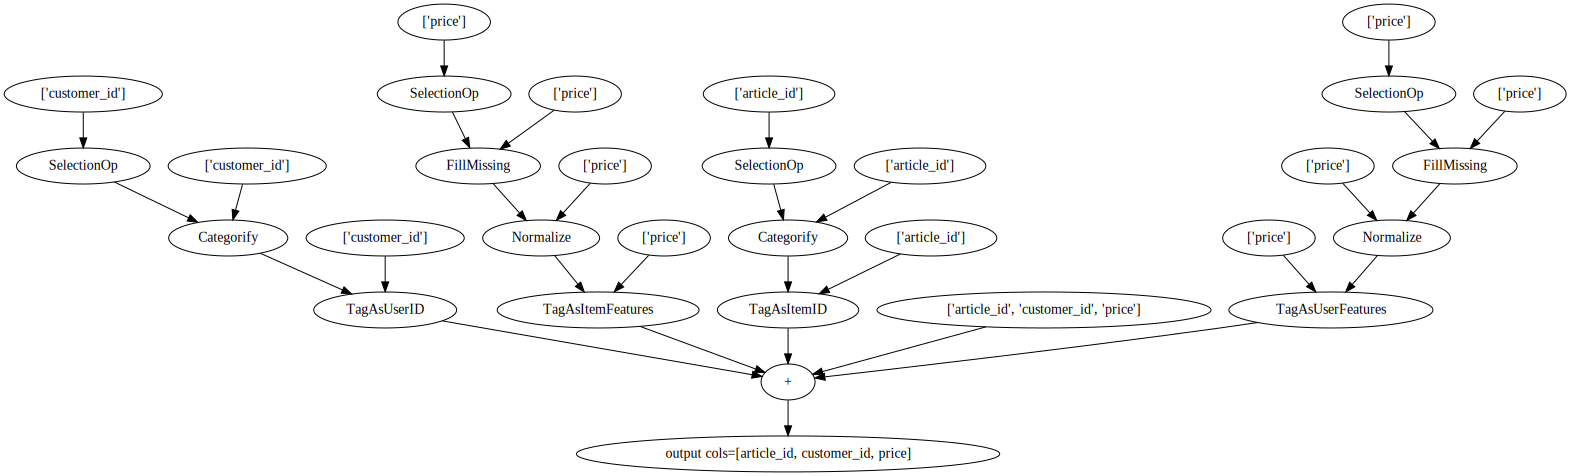

In [ ]:
features.graph

In [ ]:
schema = schema.select_by_tag([Tags.ITEM_ID, Tags.USER_ID, Tags.ITEM, Tags.USER])
label_names = schema.select_by_tag(Tags.TARGET).column_names
label_names

[]

In [ ]:
model = mm.TwoTowerModel(
    schema,
    query_tower=mm.MLPBlock([512, 256, 128, 64], no_activation_last_layer=True),
    samplers=[mm.InBatchSampler()],
    embedding_options=mm.EmbeddingOptions(infer_embedding_sizes=True),
)

In [ ]:
model.compile(optimizer="adam", run_eagerly=False, metrics=[mm.RecallAt(30), mm.NDCGAt(30)])
ree = model.fit(train, validation_data=valid, batch_size=4000, epochs=2)

Epoch 1/2


2023-08-07 11:20:16.236842: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2057/2058 [============================>.] - ETA: 0s - loss: 5.1975 - recall_at_30: 0.3646 - ndcg_at_30: 0.1264 - regularization_loss: 0.0000e+00 - loss_batch: 5.1975

2023-08-07 11:21:35.759378: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2058/2058 [==============================] - 92s 44ms/step - loss: 5.1974 - recall_at_30: 0.3647 - ndcg_at_30: 0.1264 - regularization_loss: 0.0000e+00 - loss_batch: 5.1972 - val_loss: 5.1880 - val_recall_at_30: 0.3571 - val_ndcg_at_30: 0.1324 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 4.3999
Epoch 2/2
2058/2058 [==============================] - 91s 44ms/step - loss: 5.1130 - recall_at_30: 0.4098 - ndcg_at_30: 0.1469 - regularization_loss: 0.0000e+00 - loss_batch: 5.1127 - val_loss: 4.9908 - val_recall_at_30: 0.3750 - val_ndcg_at_30: 0.1420 - val_regularization_loss: 0.0000e+00 - val_loss_batch: 4.0074


In [ ]:
ree.history


{'loss': [5.197389125823975, 5.113049030303955],
 'recall_at_30': [0.3891133964061737, 0.41745230555534363],
 'ndcg_at_30': [0.1365073323249817, 0.14985257387161255],
 'regularization_loss': [0.0, 0.0],
 'loss_batch': [4.951499938964844, 4.573450088500977],
 'val_loss': [5.187994480133057, 4.990819931030273],
 'val_recall_at_30': [0.3571337163448334, 0.37501850724220276],
 'val_ndcg_at_30': [0.13236449658870697, 0.141963392496109],
 'val_regularization_loss': [0.0, 0.0],
 'val_loss_batch': [4.39992618560791, 4.00742769241333]}

In [ ]:
eval = model.evaluate(valid, batch_size=1000, return_dict=True)

  37/3707 [..............................] - ETA: 10s - loss: 3.5135 - recall_at_30: 0.7292 - ndcg_at_30: 0.3115 - regularization_loss: 0.0000e+00 - loss_batch: 3.5135

2023-08-07 11:31:44.128675: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3707/3707 [==============================] - 10s 3ms/step - loss: 3.6357 - recall_at_30: 0.6752 - ndcg_at_30: 0.2904 - regularization_loss: 0.0000e+00 - loss_batch: 3.6345


In [ ]:
metrics

{'test_loss': 3.6357033252716064,
 'test_recall_at_30': 0.6659395694732666,
 'test_ndcg_at_30': 0.2925361692905426,
 'test_regularization_loss': 0.0,
 'test_loss_batch': 1.2351911067962646}

In [ ]:
# rename keys of eval to have test prefix
metrics = {}
for key in eval.keys():
    metrics['test_'+key] = eval[key]


In [ ]:
model.evaluate(valid, batch_size=1000, return_dict=True)

  34/3089 [..............................] - ETA: 9s - loss: 7.0239 - recall_at_30: 0.0353 - ndcg_at_30: 0.0112 - regularization_loss: 0.0000e+00 - loss_batch: 7.0239

2023-08-02 16:03:29.295270: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3089/3089 [==============================] - 9s 3ms/step - loss: 7.0094 - recall_at_30: 0.0374 - ndcg_at_30: 0.0119 - regularization_loss: 0.0000e+00 - loss_batch: 7.0092


{'loss': 7.009433269500732,
 'recall_at_30': 0.03781740367412567,
 'ndcg_at_30': 0.012081457301974297,
 'regularization_loss': 0.0,
 'loss_batch': 6.611358165740967}